# Monge, Bregman and Occam: Interpretable Optimal Transport in High-Dimensions with Feature-Sparse Maps 

## Abstract

In this tutorial, we cover how to solve high dimensional optimal transport problems with feature-sparse maps based on the paper [Monge, Bregman and Occam: Interpretable Optimal Transport in High-Dimensions with Feature-Sparse Maps](https://proceedings.mlr.press/v202/cuturi23a.html).

We propose a new model using translation-invariant costs and a regularizer. By choosing a sparsity-inducing norm for the regularizer, it produces sparse displacement vectors, simplifying the transport process. This method effectively estimates meaningful OT maps for high-dimensional data without dimensionality reduction.

## Introduction

#### Optimal Transport in Machine Learning
In the realm of machine learning, Optimal Transport serves as a fundamental tool for transferring observations from a source to a target probability measure, finding applications in domain adaptation, generative model training, and dataset realignment across various disciplines. The practical efficacy and guiding theoretical principles of OT computational approaches are underscored.

#### Challenges and Solutions in High-Dimensional Transport
 However, challenges arise when dealing with high-dimensional spaces, where the conventional choice of cost function, often based on the Euclidean distance, loses significance due to the curse of dimensionality. While dimensionality reduction techniques like PCA or VAE are commonly employed, they may yield transport maps that are difficult to interpret in the original space. To address this, the [paper](https://proceedings.mlr.press/v202/cuturi23a.html) introduces an innovative approach utilizing the sparsity toolbox to construct Optimal Transport maps that are both simpler and adaptive to input. This method involves leveraging generalized entropic maps and elastic-type regularizers to produce sparse displacements, allowing for effective interpretation and application in extremely high-dimensional datasets, as exemplified in the analysis of single-cell transcription data.

## Imports 

In [ ]:
import torchvision.datasets as datasets
import numpy as np
import os
from functools import partial
from jax import jit
import jax
import jax.numpy as jnp
import torchvision
import jax.random as random
import matplotlib.pyplot as plt
import ott

/home/tordjx/miniconda3/envs/rapidsjpp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Mathematical framework

In the following, we consider a translation-invariant cost function $c(x, y) := h(x − y)$, where $h : \mathbb{R}^d \to \mathbb{R}$. Especially, we focus on elastic-type cost functions which are strongly convex and can be expressed as a combination of a quadratic term and a sparsity-inducing function $\tau$.

$$h(z) := \frac{1}{2}   \| z \|  ^2 + \tau (z) $$

We can compute the Monge map under elastic-type costs thanks to:

**Proposition 1.** For h elastic-type costs and $x \in \Omega_{\hat{\nu}_m}(τ )$ one has:

$$ T_{h, \epsilon} (x) = x - \text{prox}_{\tau} ( x - \sum_{j=1}^m p^j (x) (y^j - \nabla \tau (x - y^j)))$$

In our framework, we explore 2 differents cost function $\tau$.

**Norm $\ell_1$** : $$ \tau (z) = \gamma \| z \|_1 $$ where $\text{prox}_{\gamma \ell_1} (z) = \text{ST}(z, \gamma) = (1 - \frac{\gamma}{\left| z \right|})_+ \circ z $  is  the *soft-thresholding operator*. 

We also have $ \nabla h(z) = z + \gamma \text{sign}(z) $ for $z$ with no 0 coordinate. 

Thus, according to **Propostion 1.** we find that the Monge map is $$ T_{\gamma \ell_1,\epsilon}(x) = x - \text{ST}_{\gamma} ( x - \sum_{j=1}^m p^j (x) (y^j + \gamma \text{sign} (x - y^j))) $$

The soft-thresholding operator works to produce, locally, sparse displacements on certain coordinates. Moreover, it also shrinks value : when a coordinate is greater than $\gamma$, it is reduced by $\gamma$. But yhis effect can lead to some “shortening” of displacement lengths in the entropic maps.

**Soft Thresholding with Vanishing Shrinkage (STVS)**

To overcome the problem of *shortening* of the norm $\ell_1$, we use the STVS : 

$$ \tau (z) = \gamma^2 \mathbb{1}_d^T (\sigma(z) + \frac{1}{2} - \frac{1}{2} \exp^{-2 \sigma (z)} ) \quad \text{with} \quad \sigma (z) := \text{asinh}(\frac{z}{2 \gamma})$$ 

where $\text{prox}_{\tau_{stvs}} = ( 1 - \frac{\gamma^2}{\left| z \right| ^2})_+ \circ z$.

We also have that the Hessian of $\tau_{stvs}$ is a diagonal matrix with values $\frac{1}{2} \left| z \right| / \sqrt{z^2 + \gamma^2} - \frac{1}{2}$.

Evaluating the map for a single point involves computing the gradient of the entropic potential followed by a single proximal operator evaluation. This implementation is facilitated by defining a class of regularized translation invariant cost functions, termed RegTICost, which specifies both the regularizer $\tau$ for Sinkhorn and its proximal operator for map evaluation. This entire process can be easily executed using the OTT-JAX library.

In [ ]:
from typing import Any
from jax.numpy import ndarray
from ott.geometry.costs import TICost

def sigma(z) :
    return jnp.arcsinh(z)


#maybe regti should herit from ticost

@jax.tree_util.register_pytree_node_class
class RegTICost(TICost) :
    def __init__(self, cost = lambda x : 0.5*jnp.sum(x**2),reg_name ="l1",gamma=0.1 ) :
        super().__init__()
        self.reg_name = reg_name
        self.cost = cost
        if self.reg_name not in [None,'l1','stvs' ]:
            raise Exception("Norm name must be one of l1, stvs, None")
        self.gamma = gamma
    def reg(self,z) :
        if self.reg_name == "l1" :
            return self.gamma * jnp.sum(abs(z))
        elif self.reg_name == "stvs" :
            return self.gamma**2 * jnp.sum((sigma(z) + 0.5 -0.5 *jnp.exp(-2*sigma(z))))
        else :
            return 0 #prox of 0 function is identity
    def h(self, z) :
        return self.cost(z) + self.reg(z)

    def prox_reg(self,z) :
        if self.reg_name == "l1" :
            return jnp.where((1-self.gamma/abs(z))>0,(1-self.gamma/abs(z)),0) * z
        elif self.reg_name == "stvs" :
            return jnp.where((1-self.gamma**2/(abs(z)**2))>0,(1-self.gamma**2/(abs(z)**2)),0) * z
        else :
            return z
    def h_legendre(self, z: jnp.ndarray) -> float:
        q = self.prox_reg(jax.lax.stop_gradient(z))
        return jnp.sum(q * z) - self.h(q) #JUSTIFIER !!!!!!



## Experiments

We study here two synthetic problems where the sparsity pattern of a ground truth transport is either constant across x or split across two areas.

### Constant sparsity-pattern

Here $$\mu = \mathcal{U}_{[0,1]^d}$$
For an integer $s < d$, we set $\nu = T_s^* \# \mu$, where the map $T_s^*$ acts on coordinates independently with the formula $T_s^*(x) = [\exp(x_1), . . . , \exp(x_s), x_{s+1}, . . . , x_d]$ (it only changes the first s coordinates of the vector, and corresponds to a sparse displacement when $s \ll d$).

For this synthetic example, the sparsity pattern is fixed across samples.

We generate n = 1.000 *i.i.d.* samples $x^i$ from $\mu$, and $y^j$ from $\nu$ independently; the samples $y^j$ are obtained by first generating fresh i.i.d. samples $\tilde{x}^j$ from $\mu$ and then pushing them $y^j := T_s^* (\tilde{x}^j)$.


In [ ]:
n=  1000
s= 5
def sample_mu(n ,d, key) :
    return jnp.asarray(jax.random.uniform(key, (n,d))) #returns the whole sampled data
def compute_transport(x,s) : #takes a matrix as input
    return jnp.concatenate(( jnp.exp(x[:,:s]), x[:,s:]),-1)

def sample_data(d):
    #Sample xi :
    rng = jax.random.PRNGKey(0)
    rng1, rng2 = jax.random.split(rng)
    x = sample_mu(n,d ,rng1)
    #Sample yi
    x_tilde = sample_mu(n,d ,rng2)
    y = compute_transport(x_tilde,s)
    return x ,y

We measure our ability to recover $T_s^*$ from $T_{h, \epsilon}$ using a normalized MSE defined as $$\frac{1}{nd} \sum_{i=1}^n \| T_s^*(x^i) -  T_{h, \epsilon} (x^i) \| ^2$$

We also measure how well our method indentifies the correct support: for each sample, we compute the support error as $\sum_{i = s+1}^d \Delta_i^2 / \sum_{i = 1}^d \Delta_i^2$ with $\Delta$ the displacement $T_{h, \epsilon}(x) - x$.

In [ ]:
#Define normalized MSE and support error
def normalized_mse(y, y_pred) :
    return (1/ jnp.prod(np.array(y.shape))) * jnp.sum((y-y_pred)**2)
def support_error(y, y_pred,x) :
    delta = y_pred -x
    return jnp.sum(delta[:,s:]**2)/ (jnp.sum(delta**2) * y.shape[0]) #à vérifier !!!!

We vary d accross the experiments and try with the 2 different costs : $\ell_1$ and STVS and compare it to the classical $\ell_2^2$ cost.

In [ ]:
result ={}
from tqdm import tqdm
for gamma in  tqdm(jnp.linspace(1e-2,1e1, 10)) : #peut etre trop de points
    for d in [8,20,100]:
        for reg_name in [None,'l1', "stvs"]:
            x ,y = sample_data(d)
            cost = RegTICost(reg_name=reg_name, gamma=gamma)
            epsilon=0.1
            geom = ott.geometry.pointcloud.PointCloud(x, y, cost_fn=cost,scale_cost = "mean")
            problem = ott.problems.linear.linear_problem.LinearProblem(geom)
            solver = ott.solvers.linear.sinkhorn.Sinkhorn(threshold=epsilon)
            out = solver(problem)
            y_pred = out.to_dual_potentials().transport(x)
            nmse = normalized_mse(y , y_pred)
            s_error = support_error(y, y_pred, x)
            if reg_name is None :
              reg_name = "none"
            result[str(gamma)+"|"+str(d)+"|"+reg_name] = (nmse, s_error)

In [ ]:
gammas = []
ds = []
reg_names = []
nmses = []
s_errors = []

# Parse result dictionary
for k, v in result.items():
    gamma, d, reg_name = k.split('|')
    nmse, s_error = v
    gammas.append(float(gamma))
    ds.append(int(d))
    reg_names.append(reg_name)
    nmses.append(nmse)
    s_errors.append(s_error)

In [ ]:
import pandas as pd
# Create DataFrame
df = pd.DataFrame({
    'Gamma': gammas,
    'D': ds,
    'Reg_Name': reg_names,
    'NMSE': nmses,
    'S_Error': s_errors
})
df.to_csv("df1.csv")

In [5]:
import pandas as pd
df = pd.read_csv("df1.csv")

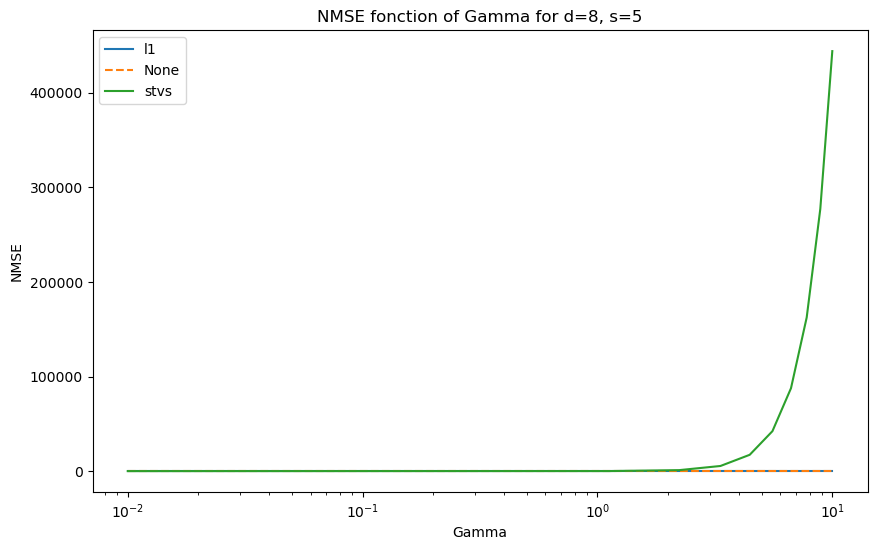

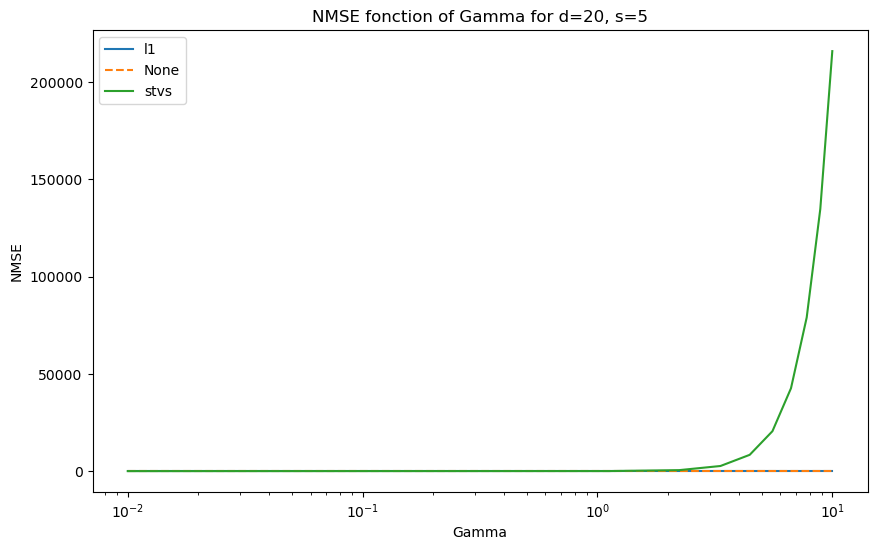

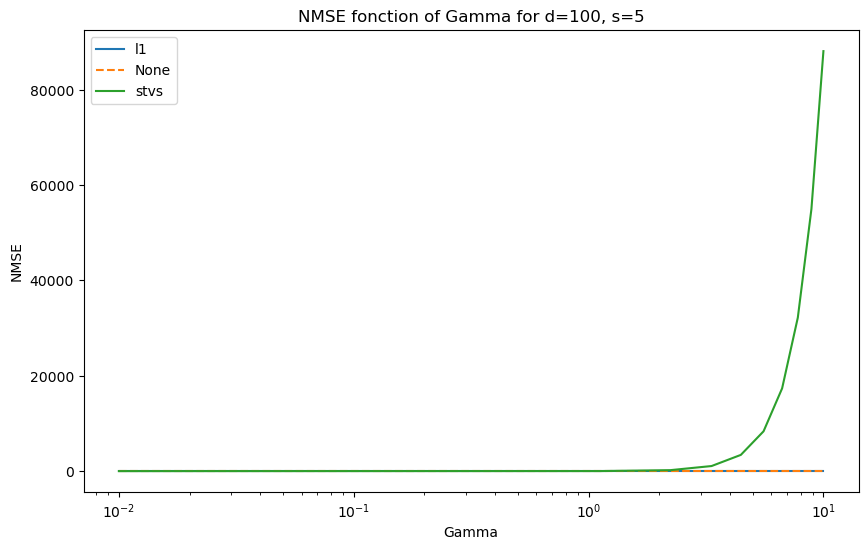

In [25]:
import matplotlib.pyplot as plt

for d_value, d_group in df.groupby('D'):
    fig, ax = plt.subplots(figsize=(10, 6))
    for key, grp in d_group.groupby('Reg_Name'):
        if key=="none":
            ax.plot(grp['Gamma'], grp['NMSE'], linestyle='dashed', label='None')
        else:
            ax.plot(grp['Gamma'], grp['NMSE'], label=key)

    ax.set_xlabel('Gamma')
    ax.set_ylabel('NMSE')
    ax.set_title(f'NMSE fonction of Gamma for d={d_value}'+', s=5')
    ax.set_xscale('log')
    ax.legend()
    plt.show()


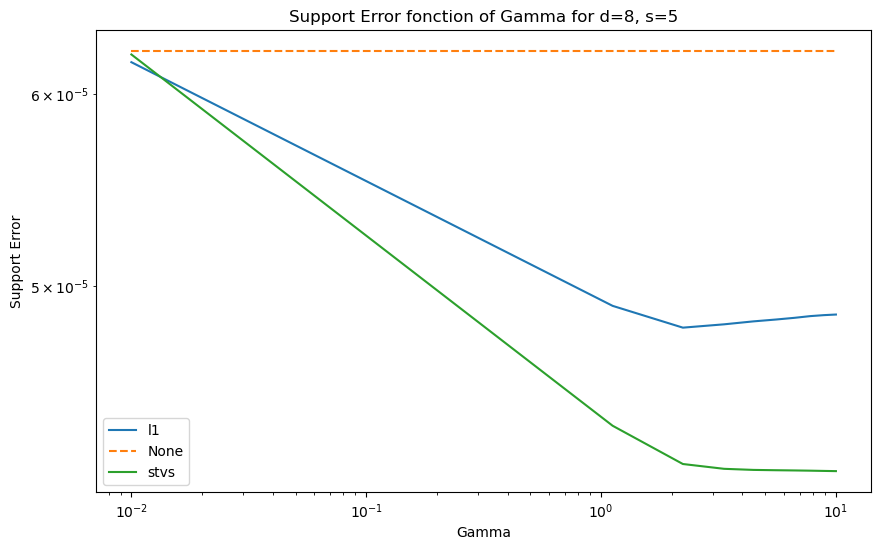

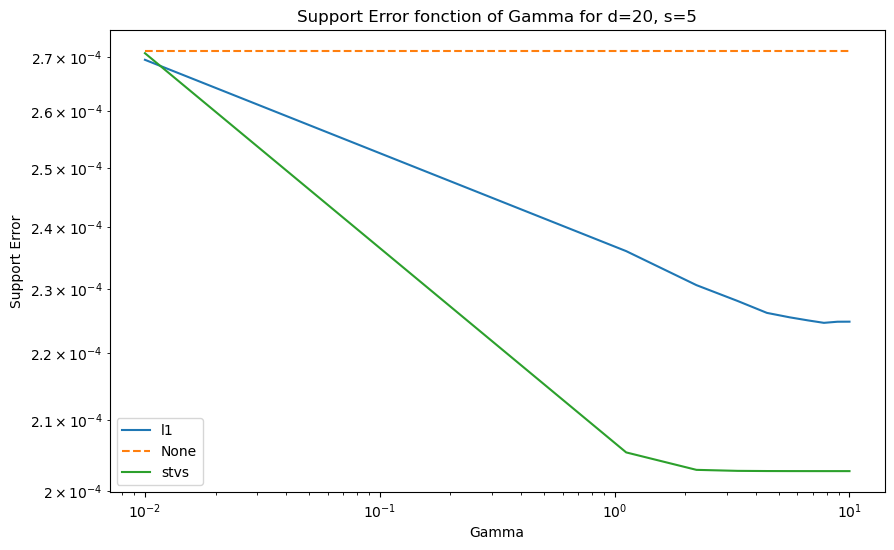

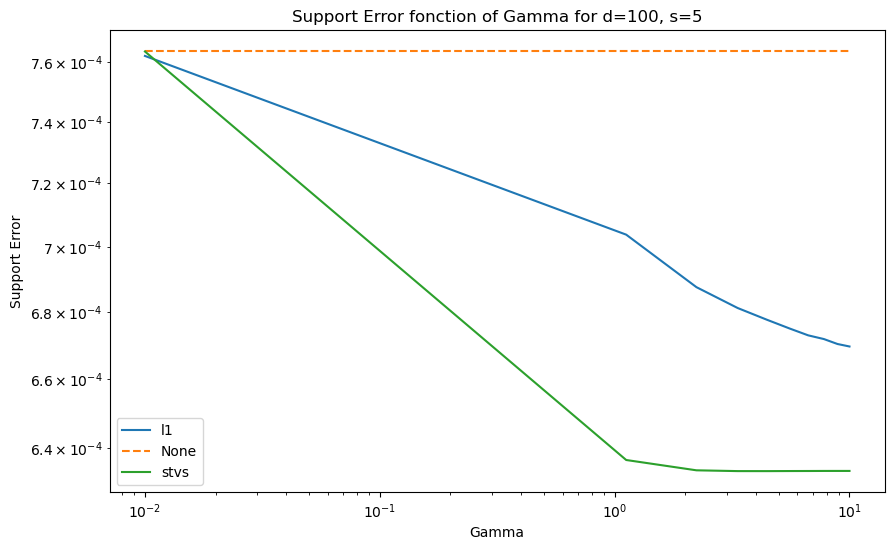

In [45]:
for d_value, d_group in df.groupby('D'):
    fig, ax = plt.subplots(figsize=(10, 6))
    for key, grp in d_group.groupby('Reg_Name'):
        if key=="none":
            ax.plot(grp['Gamma'], grp['S_Error'], linestyle='dashed', label='None')
        else:
            ax.plot(grp['Gamma'], grp['S_Error'], label=key)

    ax.set_xlabel('Gamma')
    ax.set_ylabel('Support Error')
    ax.set_title(f'Support Error fonction of Gamma for d={d_value}'+', s=5')
    ax.set_xscale('log')  
    ax.set_yscale('log')  
    ax.legend()
    plt.show()


- When $d \approx s$ : the 

- When $d > s$ : 

- When $d \gg s$ : 

### x-dependent sparsity-pattern

To illustrate the ability of our method to recover transport maps whose sparsity pattern is adaptive, depending on the input x, we extend the previous setting as follows.

In [ ]:
n = 100
s= 2
def F(x,s) :
    n1 = jnp.sum(x[:s]**2)
    n2 = jnp.sum(x[s:2*s]**2)
    if n1> n2 :
        return jnp.concatenate(( jnp.exp(x[:,:s]), x[:,s:]),-1)

    else :
        return  jnp.concatenate(( x[:,:s], jnp.exp(x[:,s:2*s]), x[:,2*s:]),-1)
    
def sample_data(d):
    #Sample xi :
    rng = jax.random.PRNGKey(0)
    rng1, rng2 = jax.random.split(rng)
    x = sample_mu(n,d ,rng1)
    #Sample yi
    x_tilde = sample_mu(n,d ,rng2)
    y = F(x_tilde,s)
    return x ,y

We measure our ability to recover $T_s^*$ from $T_{h, \epsilon}$ using a normalized MSE and the support error as previously.

We vary d accross the experiments and try with the 2 different costs : $\ell_1$ and STVS and compare it to the classical $\ell_2^2$ cost.

In [ ]:
result = {}
for d in tqdm(jnp.linspace(1e1, 1e3, 10)):
    d = int(d)
    for reg_name in ['l1', "stvs", None]:
        for gamma in  jnp.linspace(1e-2,1e1, 10) : #We'll keep the value of lowest NMSE
            x ,y = sample_data(d)
            cost = RegTICost(reg_name=reg_name, gamma=gamma)
            epsilon=0.1
            geom = ott.geometry.pointcloud.PointCloud(x, y, cost_fn=cost,scale_cost = "mean")
            problem = ott.problems.linear.linear_problem.LinearProblem(geom)
            solver = ott.solvers.linear.sinkhorn.Sinkhorn(threshold=epsilon)
            out = solver(problem)
            y_pred = out.to_dual_potentials().transport(x)
            nmse = normalized_mse(y , y_pred)
            if reg_name is None :
              reg_name = "none"
            if str(d)+"|"+reg_name not in result.keys() or result[str(d)+"|"+reg_name]>nmse:
                result[str(d)+"|"+reg_name] = nmse
            if reg_name == "none" :
              reg_name = None

100%|██████████| 10/10 [02:00<00:00, 12.08s/it]


In [ ]:
#process the data and plot
ds = []
reg_names = []
nmses = []

# Parse result dictionary
for k, v in result.items():
    d, reg_name = k.split('|')
    nmse = v
    ds.append(int(d))
    reg_names.append(reg_name)
    nmses.append(nmse)

In [ ]:
import pandas as pd
# Create DataFrame
df = pd.DataFrame({
    'D': ds,
    'Reg_Name': reg_names,
    'NMSE': nmses,
})
df.to_csv("df2.csv")

In [37]:
import pandas as pd
df2 = pd.read_csv("df2.csv")

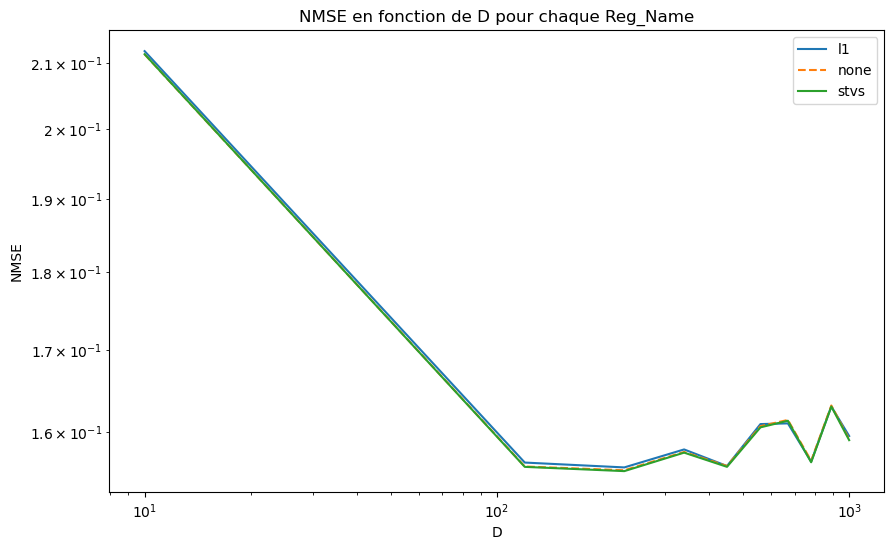

In [44]:
fig, ax = plt.subplots(figsize=(10, 6))

# Tracer NMSE en fonction de D pour chaque Reg_Name
for reg_name, reg_group in df2.groupby('Reg_Name'):
    if reg_name != "none":
        ax.plot(reg_group['D'], reg_group['NMSE'], label=reg_name)
    else:
        ax.plot(reg_group['D'], reg_group['NMSE'], linestyle='dashed', label="none")

# Paramètres du graphique
ax.set_xlabel('D')
ax.set_ylabel('NMSE')
ax.set_title('NMSE en fonction de D pour chaque Reg_Name')
ax.set_xscale('log')  
ax.set_yscale('log')  
ax.legend()
plt.show()

As expected, we observe a much better scaling for our costs than for the standard $\ell_2^2$ cost, indicating that sparsity-inducing costs mitigate the
curse of dimensionality.

## Conclusion

By selecting elastic-type costs, which combine an $\ell_2$ term with a sparsifying term, the maps exhibit sparsity, impacting only a subset of coordinates adaptively. Future extensions may include utilizing more informative sparsity-inducing norms and leveraging Bregman geometry for more complex Wasserstein distance problems such as barycenters.